In [272]:
## Import packages
library(aod)
library(plyr)
library(mgcv)
library(stringr)
library(stargazer)
library(dplyr)
library(corrplot)
library(purrr)
library(ggplot2)
install.packages("performance")


also installing the dependencies ‘bayestestR’, ‘insight’, ‘datawizard’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


## Prepare dataframe

### Public School Location Data

In [55]:
public_school_location_info = read.csv("public_school_location_info.csv")
# colnames(public_school_location_info)
public_school_location_info = select(public_school_location_info, "School", "Charter", "Latitude", "Longitude", "EILName", "District")
public_school_location_info <- filter(public_school_location_info, Latitude != 'No Data' & Longitude != 'No Data' & EILName == 'Elementary' & School != 'No Data')
head(public_school_location_info)

School,Charter,Latitude,Longitude,EILName,District
Community School for Creative Education,Y,37.784648,-122.23863,Elementary,Alameda County Office of Education
Yu Ming Charter,Y,37.847375,-122.28356,Elementary,Alameda County Office of Education
Urban Montessori Charter,Y,37.786794,-122.18817,Elementary,Alameda County Office of Education
Hayward Collegiate Charter,Y,37.648124,-122.08239,Elementary,Alameda County Office of Education
Cox Academy,Y,37.746513,-122.16182,Elementary,Alameda County Office of Education
Lazear Charter Academy,Y,37.776239,-122.23207,Elementary,Alameda County Office of Education


### SEDA Data for public schools

In [56]:
seda_data_for_public_schools = read.csv("seda_school_pool_cs_4.1.csv")
# colnames(seda_data_for_public_schools)
seda_data_for_public_schools = select(seda_data_for_public_schools, -"sedasch", -"fips", -"subcat", -"subgroup", -"gradecenter", -"gap", -"cellcount", -"mn_asmts")
seda_data_for_public_schools$School <- seda_data_for_public_schools$sedaschname
seda_data_for_public_schools = select(seda_data_for_public_schools, -"sedaschname")
seda_data_for_public_schools <- filter(seda_data_for_public_schools, stateabb == 'CA')
before = nrow(seda_data_for_public_schools)
seda_data_for_public_schools = na.omit(seda_data_for_public_schools)
after = nrow(seda_data_for_public_schools)
str_interp("Omitted $[.f]{before - after} rows by removing anything with NA values")
head(seda_data_for_public_schools)

[1] "Omitted 2339 rows by removing anything with NA values"

,stateabb,tot_asmts,cs_mn_avg_ol,cs_mn_coh_ol,cs_mn_grd_ol,cs_mn_mth_ol,cs_mn_avg_ol_se,cs_mn_coh_ol_se,cs_mn_grd_ol_se,cs_mn_mth_ol_se,cs_mn_avg_eb,cs_mn_coh_eb,cs_mn_grd_eb,cs_mn_mth_eb,cs_mn_avg_eb_se,cs_mn_coh_eb_se,cs_mn_grd_eb_se,cs_mn_mth_eb_se,School
2,CA,3815,-0.2057509,-0.002543360,0.04510366,-0.12993206,0.02712490,0.008901680,0.03400741,0.05401088,-0.2050351,-0.002486500,0.034018458,-0.1123695,0.02705193,0.008588411,0.02936181,0.05006016,Meadowlark Elementary
3,CA,4383,-0.1945876,0.016586582,0.01278513,-0.17509063,0.02921618,0.010488541,0.03369059,0.06146289,-0.1905063,0.013795592,0.015360364,-0.1447053,0.02891944,0.009849191,0.02889895,0.05554290,High Desert
5,CA,3189,0.2052310,0.003285205,0.11761112,-0.32920201,0.02793839,0.009558235,0.03513335,0.05572500,0.2032434,0.003160816,0.085764398,-0.2772184,0.02788258,0.009170558,0.03017293,0.05143605,Manor Elementary
6,CA,8468,0.5612020,0.022074864,-0.01224602,-0.22112266,0.02992426,0.009409591,0.03570866,0.05851852,0.5661908,0.020250401,-0.002238481,-0.1817763,0.02922588,0.009009090,0.03047804,0.05344632,White Hill Middle
7,CA,3422,0.8283346,0.058297468,0.08678017,-0.09832165,0.03206196,0.009972555,0.04028447,0.06313811,0.8220252,0.054241424,0.071037997,-0.0738407,0.03188546,0.009535340,0.03315735,0.05706946,Brookside Elementary
8,CA,3079,0.6144864,0.056051793,0.18685540,-0.22761354,0.02863086,0.009510926,0.03545272,0.05726117,0.6096649,0.052356484,0.145065694,-0.1873351,0.02856221,0.009130468,0.03034412,0.05264635,Wade Thomas Elementary


### Merge "Public School Location Data" & "SEDA Data for public schools"

In [58]:
df <- merge(seda_data_for_public_schools, public_school_location_info,by="School")
head(df)
colnames(df)

School,stateabb,tot_asmts,cs_mn_avg_ol,cs_mn_coh_ol,cs_mn_grd_ol,cs_mn_mth_ol,cs_mn_avg_ol_se,cs_mn_coh_ol_se,cs_mn_grd_ol_se,...,cs_mn_mth_eb,cs_mn_avg_eb_se,cs_mn_coh_eb_se,cs_mn_grd_eb_se,cs_mn_mth_eb_se,Charter,Latitude,Longitude,EILName,District
A. E. Arnold Elementary,CA,7593,0.2559182,0.021824821,0.066488788,-0.01646314,0.02229070,0.007333276,0.02117757,...,-0.01316489,0.02225694,0.007150848,0.01997353,0.04221594,N,33.826825,-118.05576,Elementary,Cypress Elementary
A. G. Cook Elementary,CA,3802,0.3072644,0.106203990,0.075156635,0.18127809,0.02423982,0.008039868,0.02282817,...,0.16067999,0.02420183,0.007805582,0.02133288,0.04549659,N,33.763632,-117.95840,Elementary,Garden Grove Unified
A. J. Dorsa Elementary,CA,4459,-0.5904406,-0.009485188,0.073868214,0.08848730,0.02746552,0.009225629,0.03411214,...,0.07351242,0.02740213,0.008876019,0.02948585,0.05056527,N,37.339098,-121.83791,Elementary,Alum Rock Union Elementary
A. L. Conner Elementary,CA,3203,-0.5493198,0.025556702,0.057698599,0.03772213,0.02669967,0.008840996,0.03395766,...,0.02973817,0.02664580,0.008534264,0.02932782,0.04953226,N,36.629881,-119.30945,Elementary,Kings Canyon Joint Unified
A. M. Winn Waldorf-Inspired,CA,3771,-0.5503489,-0.035372641,0.007705477,0.11651859,0.02675090,0.008564356,0.01868914,...,0.10043028,0.02646339,0.008256189,0.01778388,0.04583943,N,38.566539,-121.32497,Elementary,Sacramento City Unified
ACORN Woodland Elementary,CA,2166,-0.2577003,-0.026600789,0.059886600,0.00598175,0.02881002,0.009497497,0.03731055,...,0.00695927,0.02874990,0.009113085,0.03141492,0.05289405,N,37.752862,-122.18605,Elementary,Oakland Unified


[1] "School"          "stateabb"        "tot_asmts"       "cs_mn_avg_ol"   
 [5] "cs_mn_coh_ol"    "cs_mn_grd_ol"    "cs_mn_mth_ol"    "cs_mn_avg_ol_se"
 [9] "cs_mn_coh_ol_se" "cs_mn_grd_ol_se" "cs_mn_mth_ol_se" "cs_mn_avg_eb"   
[13] "cs_mn_coh_eb"    "cs_mn_grd_eb"    "cs_mn_mth_eb"    "cs_mn_avg_eb_se"
[17] "cs_mn_coh_eb_se" "cs_mn_grd_eb_se" "cs_mn_mth_eb_se" "Charter"        
[21] "Latitude"        "Longitude"       "EILName"         "District"

### Walkability data

In [108]:
walkability_data <- read.csv("EPA_SmartLocationDatabase_V3_Jan_2021_Final.csv")
head(walkability_data)
walkability_data = select(walkability_data, "STATEFP", "COUNTYFP", "TRACTCE", "NatWalkInd", "CSA_Name", "TotPop", "Ac_Total", "Ac_Land", "Ac_Unpr", "AutoOwn0")
walkability_data <- filter(walkability_data, STATEFP == 6) # 6 = CA
walkability_data = select(walkability_data, -"STATEFP")
head(walkability_data)

OBJECTID,GEOID10,GEOID20,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,CSA,CSA_Name,CBSA,...,D5DRI,D5DE,D5DEI,D2A_Ranked,D2B_Ranked,D3B_Ranked,D4A_Ranked,NatWalkInd,Shape_Length,Shape_Area
1,4.8113e+11,4.8113e+11,48,113,7825,4,206,"Dallas-Fort Worth, TX-OK",19100,...,0.1846967,0.000475598,0.1377067,6,14,15,17,14.000000,3110.361,297836.1
2,4.8113e+11,4.8113e+11,48,113,7825,2,206,"Dallas-Fort Worth, TX-OK",19100,...,0.3232213,0.000800804,0.2318678,3,10,12,14,10.833333,3519.469,484945.1
3,4.8113e+11,4.8113e+11,48,113,7825,3,206,"Dallas-Fort Worth, TX-OK",19100,...,0.3146279,0.000736145,0.2131463,1,1,7,17,8.333333,1697.092,106705.9
4,4.8113e+11,4.8113e+11,48,113,7824,1,206,"Dallas-Fort Worth, TX-OK",19100,...,0.2298209,0.000708073,0.2050183,16,10,17,17,15.666667,2922.609,481828.4
5,4.8113e+11,4.8113e+11,48,113,7824,2,206,"Dallas-Fort Worth, TX-OK",19100,...,0.1648628,0.000432736,0.1252960,4,7,11,14,10.166667,3731.972,687684.8
6,4.8113e+11,4.8113e+11,48,113,7827,1,206,"Dallas-Fort Worth, TX-OK",19100,...,0.1890630,0.000467412,0.1353362,1,4,5,13,6.833333,3109.652,205126.8


COUNTYFP,TRACTCE,NatWalkInd,CSA_Name,TotPop,Ac_Total,Ac_Land,Ac_Unpr,AutoOwn0
53,11101,12.833333,,3226,346.01759,345.90491,339.58397,80
53,11102,15.333333,,4144,358.70593,358.70593,351.93580,14
97,151308,13.666667,"San Jose-San Francisco-Oakland, CA",396,67.13559,67.13559,60.29173,0
51,102,8.000000,,935,107095.36710,107046.04320,6959.85118,24
97,151309,10.666667,"San Jose-San Francisco-Oakland, CA",2560,570.03721,570.03721,471.33595,8
97,151309,9.833333,"San Jose-San Francisco-Oakland, CA",1610,982.99741,982.99741,982.84633,77


In [107]:
# 060670090041017
# filter(walkability_data, TRACTCE == 000102)

### Request tract info with lat and lon data 

In [92]:
library(httr)
library(jsonlite)


Attaching package: ‘jsonlite’

The following object is masked from ‘package:purrr’:

    flatten



In [150]:
get_FIPS <- function(lat, lon) {
    req = str_interp("https://geo.fcc.gov/api/census/block/find?latitude=${lat}&longitude=${lon}&censusYear=2010&showall=false&format=json", list(lat = lat, lon = lon))
    res <- GET(req)
    jsondata=fromJSON(rawToChar(res$content))
    return(jsondata$Block$FIPS)
}

In [153]:
df_size = nrow(df)
fips_col = rep(NA, df_size)
for (i in 1:df_size) {
    row = df[i, ]
    fips_value = get_FIPS(row$Latitude, row$Longitude)
    fips_col[i] <- fips_value
}
df = cbind(df, fips_col)
df

School,stateabb,tot_asmts,cs_mn_avg_ol,cs_mn_coh_ol,cs_mn_grd_ol,cs_mn_mth_ol,cs_mn_avg_ol_se,cs_mn_coh_ol_se,cs_mn_grd_ol_se,...,cs_mn_avg_eb_se,cs_mn_coh_eb_se,cs_mn_grd_eb_se,cs_mn_mth_eb_se,Charter,Latitude,Longitude,EILName,District,fips_col
A. E. Arnold Elementary,CA,7593,0.2559182,2.182482e-02,0.066488788,-0.01646314,0.02229070,0.007333276,0.02117757,...,0.02225694,0.007150848,0.01997353,0.04221594,N,33.826825,-118.05576,Elementary,Cypress Elementary,060591101171020
A. G. Cook Elementary,CA,3802,0.3072644,1.062040e-01,0.075156635,0.18127809,0.02423982,0.008039868,0.02282817,...,0.02420183,0.007805582,0.02133288,0.04549659,N,33.763632,-117.95840,Elementary,Garden Grove Unified,060590889013005
A. J. Dorsa Elementary,CA,4459,-0.5904406,-9.485188e-03,0.073868214,0.08848730,0.02746552,0.009225629,0.03411214,...,0.02740213,0.008876019,0.02948585,0.05056527,N,37.339098,-121.83791,Elementary,Alum Rock Union Elementary,060855035041000
A. L. Conner Elementary,CA,3203,-0.5493198,2.555670e-02,0.057698599,0.03772213,0.02669967,0.008840996,0.03395766,...,0.02664580,0.008534264,0.02932782,0.04953226,N,36.629881,-119.30945,Elementary,Kings Canyon Joint Unified,060190065021005
A. M. Winn Waldorf-Inspired,CA,3771,-0.5503489,-3.537264e-02,0.007705477,0.11651859,0.02675090,0.008564356,0.01868914,...,0.02646339,0.008256189,0.01778388,0.04583943,N,38.566539,-121.32497,Elementary,Sacramento City Unified,060670090041017
ACORN Woodland Elementary,CA,2166,-0.2577003,-2.660079e-02,0.059886600,0.00598175,0.02881002,0.009497497,0.03731055,...,0.02874990,0.009113085,0.03141492,0.05289405,N,37.752862,-122.18605,Elementary,Oakland Unified,060014089001008
ASCEND,CA,4519,-0.4486530,4.704682e-06,0.071223302,0.10221407,0.02126825,0.007035316,0.01388423,...,0.02121002,0.006870726,0.01354670,0.04058423,Y,37.774031,-122.22166,Elementary,Oakland Unified,060014061001050
Abby Reinke Elementary,CA,7611,0.3670611,3.460241e-03,0.040948824,-0.14942920,0.02504173,0.008021419,0.03119012,...,0.02500259,0.007785910,0.02751624,0.04685205,N,33.491801,-117.08607,Elementary,Temecula Valley Unified,060650432651007
Abraham Lincoln,CA,5446,-0.1235943,3.176873e-02,0.002000042,0.09136202,0.04014345,0.008164994,0.02707142,...,0.03792886,0.007875712,0.02471834,0.04668160,N,33.893657,-118.15869,Elementary,Paramount Unified,060375539014002
Abraham Lincoln Elementary,CA,2967,-0.7159730,-4.055605e-02,-0.029138644,0.18234035,0.02883122,0.010341073,0.02519405,...,0.02861634,0.009868878,0.02325328,0.04955980,N,33.740758,-117.90255,Elementary,Santa Ana Unified,060590748023014


In [200]:
df_size = nrow(df)
NatWalkInd = rep(NA, df_size)
CSA_Name = rep(NA, df_size)
TotPop = rep(NA, df_size)
Ac_Total = rep(NA, df_size)
Ac_Land = rep(NA, df_size)
Ac_Unpr = rep(NA, df_size)
AutoOwn0 = rep(NA, df_size)
for (i in 1:df_size) {
    row = df[i, ]
    county = substr(as.character(row$fips_col), 3, 5) # Extract county info
    tract = substr(as.character(row$fips_col), 6, 11) # Extract tract info
    walkability_rows = filter(walkability_data, TRACTCE == as.numeric(tract) & COUNTYFP==as.numeric(county))
    if (nrow(walkability_rows) > 1) {
        name = walkability_rows$CSA_Name[1]
    } else {
        name = walkability_rows$CSA_Name
    }
    NatWalkInd[i] <- mean(walkability_rows$NatWalkInd)
    CSA_Name[i] <- as.character(name)
    TotPop[i] <- mean(walkability_rows$TotPop)
    Ac_Total[i] <- mean(walkability_rows$Ac_Total)
    Ac_Land[i] <- mean(walkability_rows$Ac_Land)
    Ac_Unpr[i] <- mean(walkability_rows$Ac_Unpr)
    AutoOwn0[i] <- mean(walkability_rows$AutoOwn0)
}
df2 = cbind(df, NatWalkInd)
df2 = cbind(df2, CSA_Name)
df2 = cbind(df2, Ac_Total)
df2 = cbind(df2, Ac_Land)
df2 = cbind(df2, Ac_Unpr)
df2 = cbind(df2, AutoOwn0)


School,stateabb,tot_asmts,cs_mn_avg_ol,cs_mn_coh_ol,cs_mn_grd_ol,cs_mn_mth_ol,cs_mn_avg_ol_se,cs_mn_coh_ol_se,cs_mn_grd_ol_se,...,Longitude,EILName,District,fips_col,NatWalkInd,CSA_Name,Ac_Total,Ac_Land,Ac_Unpr,AutoOwn0
A. E. Arnold Elementary,CA,7593,0.2559182,0.021824821,0.066488788,-0.01646314,0.02229070,0.007333276,0.02117757,...,-118.05576,Elementary,Cypress Elementary,060591101171020,14.70833,"Los Angeles-Long Beach, CA",82.34033,81.61657,80.25719,18.0
A. G. Cook Elementary,CA,3802,0.3072644,0.106203990,0.075156635,0.18127809,0.02423982,0.008039868,0.02282817,...,-117.95840,Elementary,Garden Grove Unified,060590889013005,15.79167,"Los Angeles-Long Beach, CA",120.95063,120.95063,111.91458,32.5
A. J. Dorsa Elementary,CA,4459,-0.5904406,-0.009485188,0.073868214,0.08848730,0.02746552,0.009225629,0.03411214,...,-121.83791,Elementary,Alum Rock Union Elementary,060855035041000,13.50000,"San Jose-San Francisco-Oakland, CA",55.42720,55.42720,55.42720,11.0
A. L. Conner Elementary,CA,3203,-0.5493198,0.025556702,0.057698599,0.03772213,0.02669967,0.008840996,0.03395766,...,-119.30945,Elementary,Kings Canyon Joint Unified,060190065021005,12.75000,"Fresno-Madera-Hanford, CA",1794.14146,1794.14146,1788.28297,113.0
A. M. Winn Waldorf-Inspired,CA,3771,-0.5503489,-0.035372641,0.007705477,0.11651859,0.02675090,0.008564356,0.01868914,...,-121.32497,Elementary,Sacramento City Unified,060670090041017,14.41667,"Sacramento-Roseville, CA",170.64219,170.64219,163.41358,5.5
ACORN Woodland Elementary,CA,2166,-0.2577003,-0.026600789,0.059886600,0.00598175,0.02881002,0.009497497,0.03731055,...,-122.18605,Elementary,Oakland Unified,060014089001008,14.50000,"San Jose-San Francisco-Oakland, CA",99.13726,99.13726,99.13726,116.0


In [201]:
write.csv(df2,"wip_2.csv", row.names = FALSE)

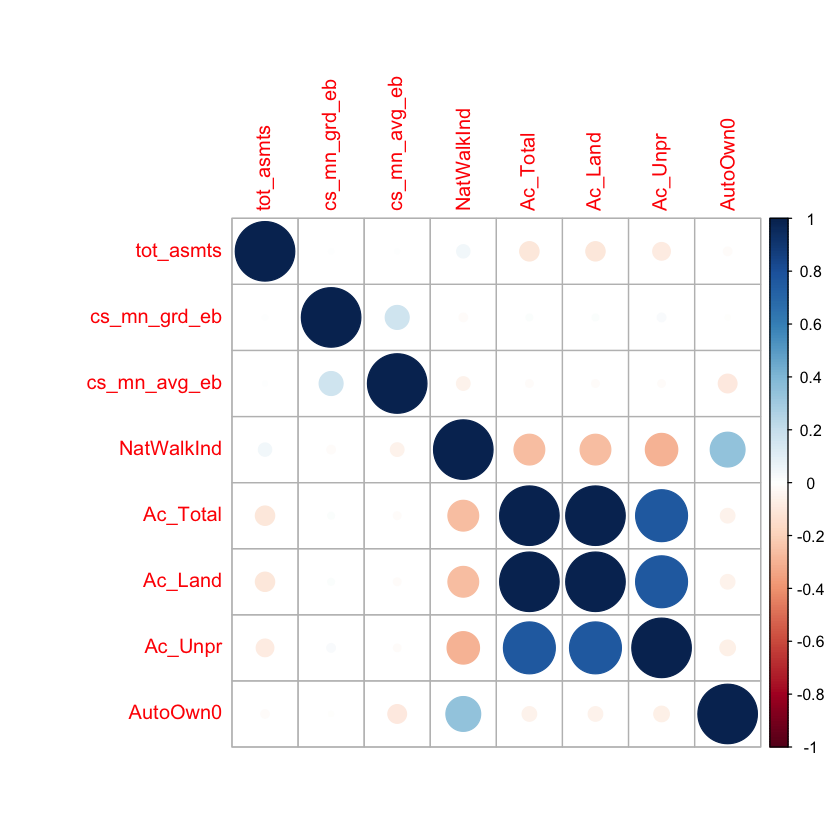

In [207]:
# missing:  "School", "Latitude", "Longitude","Charter",
df = select(df2, "tot_asmts", "cs_mn_grd_eb", "cs_mn_avg_eb", "NatWalkInd", "Ac_Total", "Ac_Land", "Ac_Unpr", "AutoOwn0")
C <- cor(df, use="pairwise.complete.obs")
corrplot(C)

In [208]:
summary(df)

   tot_asmts      cs_mn_grd_eb       cs_mn_avg_eb        NatWalkInd    
 Min.   :  305   Min.   :-0.21999   Min.   :-1.31874   Min.   : 1.333  
 1st Qu.: 3828   1st Qu.:-0.01214   1st Qu.:-0.59119   1st Qu.: 9.625  
 Median : 5078   Median : 0.02824   Median :-0.37195   Median :12.722  
 Mean   : 5273   Mean   : 0.02657   Mean   :-0.26399   Mean   :11.950  
 3rd Qu.: 6539   3rd Qu.: 0.06568   3rd Qu.: 0.02646   3rd Qu.:14.389  
 Max.   :16616   Max.   : 0.32365   Max.   : 1.48789   Max.   :19.333  
    Ac_Total            Ac_Land             Ac_Unpr            AutoOwn0     
 Min.   :     11.3   Min.   :     11.3   Min.   :    11.3   Min.   :  0.00  
 1st Qu.:    101.7   1st Qu.:    100.4   1st Qu.:    95.7   1st Qu.: 13.00  
 Median :    165.1   Median :    164.0   Median :   159.1   Median : 26.00  
 Mean   :   5337.3   Mean   :   5267.2   Mean   :  3446.9   Mean   : 37.95  
 3rd Qu.:    537.7   3rd Qu.:    524.1   3rd Qu.:   459.2   3rd Qu.: 47.80  
 Max.   :1112645.9   Max.   :11122

In [269]:
## Create Y indicator value, which equals 1 if cs_mn_avg_eb > 3rd Qu. value and 0 otherwise
df = select(df, -"high_performing")
df_size = nrow(df)
high_performing = rep(NA, df_size)
high_performing_cutoff = quantile(df$cs_mn_avg_eb, c(0.5))
for (i in 1:df_size) {
    row = df[i, ]
    is_high_performing = 0
    if (row$cs_mn_avg_eb >= high_performing_cutoff) {
        is_high_performing = 1
    }
    high_performing[i] <- is_high_performing
}
df = cbind(df, high_performing)

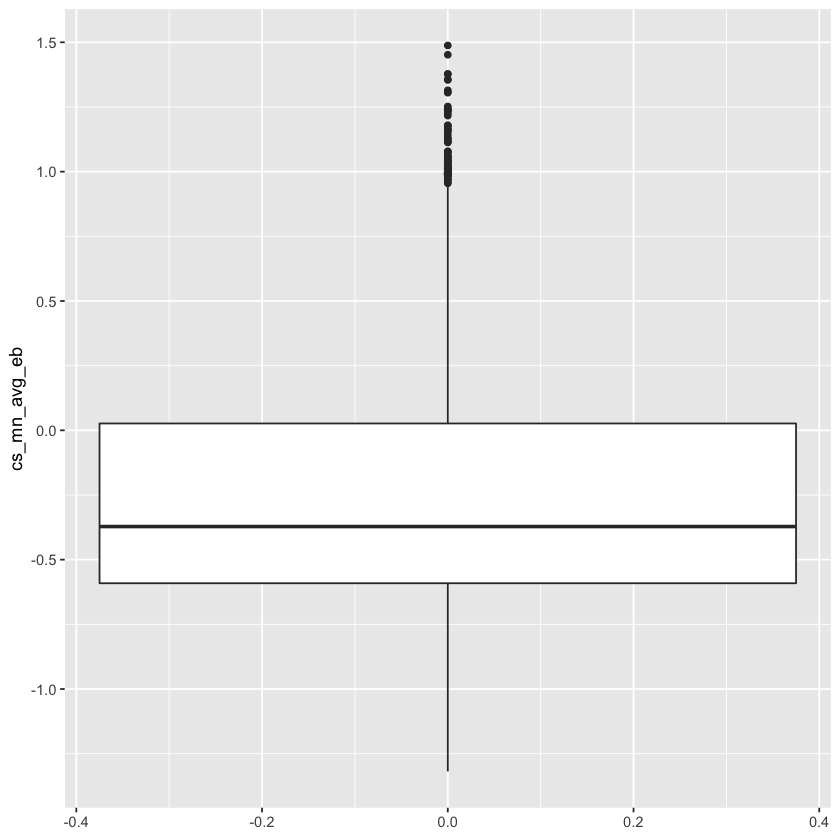

In [221]:
box_plot = ggplot(data= df, mapping=aes(y=cs_mn_avg_eb)) + geom_boxplot()
# abline(h = quantile(df$cs_mn_avg_eb, c(0.25, 0.75)), col='red')
box_plot

In [277]:
install.packages("see")
library(see)
fit = glm(high_performing ~ NatWalkInd, family ="binomial" , data=df)
summary(fit)
model_performance(fit)
check_model(fit)
plot(fit)

also installing the dependencies ‘isoband’, ‘rlang’, ‘effectsize’, ‘ggplot2’, ‘parameters’

Warning message in install.packages("see"):
“installation of package ‘isoband’ had non-zero exit status”Warning message in install.packages("see"):
“installation of package ‘rlang’ had non-zero exit status”Warning message in install.packages("see"):
“installation of package ‘ggplot2’ had non-zero exit status”Warning message in install.packages("see"):
“installation of package ‘see’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


ERROR: Error in library(see): there is no package called ‘see’



                    Dependent variable:    
                ---------------------------
                       cs_mn_avg_eb        
-------------------------------------------
s(NatWalkInd).1                            
                                           
                                           
s(NatWalkInd).2                            
                                           
                                           
s(NatWalkInd).3                            
                                           
                                           
s(NatWalkInd).4                            
                                           
                                           
s(NatWalkInd).5                            
                                           
                                           
s(NatWalkInd).6                            
                                           
                                           
s(NatWalkInd).7                

Warning message in anova.glmlist(c(list(object), dotargs), dispersion = dispersion, :
“models with response ‘"cs_mn_avg_eb"’ removed because response differs from model 1”

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,12613,17486.71,NA
NatWalkInd,1,52.40363,12612,17434.31,4.518872e-13


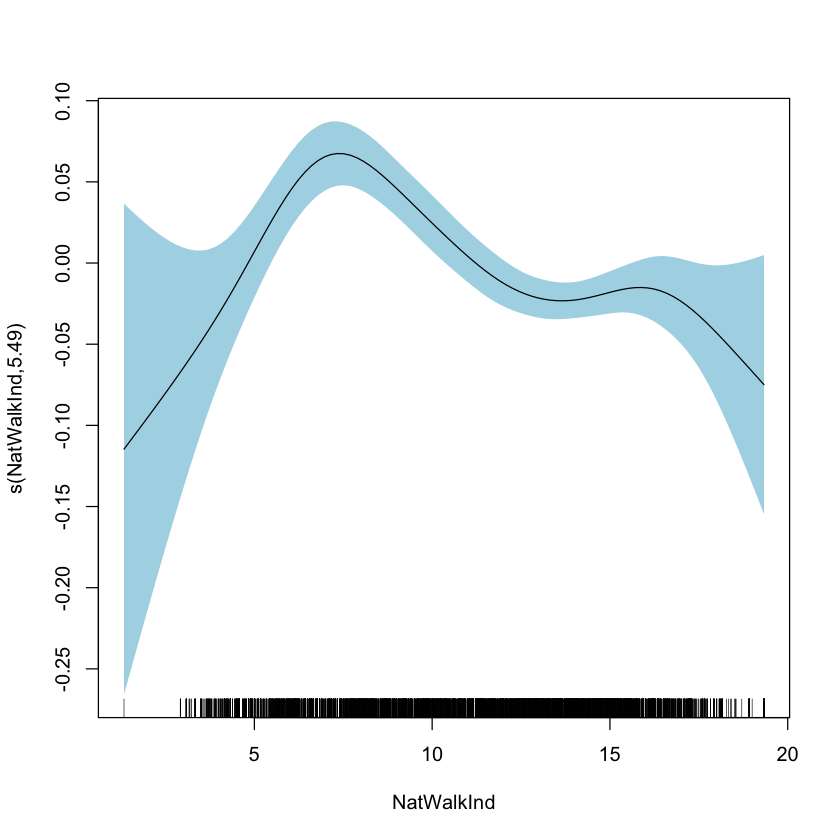

In [279]:
library(mgcv)
library(performance)
fit_gam = gam(cs_mn_avg_eb ~ s(NatWalkInd), data=df, method="REML")
stargazer(fit_gam, type="text")
plot(fit_gam, rug=T, shade=T, shade.col='lightblue')
#model_performance(fit_gam)
#check_model(fit_gam)

In [230]:
summary(df)

   tot_asmts      cs_mn_grd_eb       cs_mn_avg_eb        NatWalkInd    
 Min.   :  305   Min.   :-0.21999   Min.   :-1.31874   Min.   : 1.333  
 1st Qu.: 3828   1st Qu.:-0.01214   1st Qu.:-0.59119   1st Qu.: 9.625  
 Median : 5078   Median : 0.02824   Median :-0.37195   Median :12.722  
 Mean   : 5273   Mean   : 0.02657   Mean   :-0.26399   Mean   :11.950  
 3rd Qu.: 6539   3rd Qu.: 0.06568   3rd Qu.: 0.02646   3rd Qu.:14.389  
 Max.   :16616   Max.   : 0.32365   Max.   : 1.48789   Max.   :19.333  
    Ac_Total            Ac_Land             Ac_Unpr            AutoOwn0     
 Min.   :     11.3   Min.   :     11.3   Min.   :    11.3   Min.   :  0.00  
 1st Qu.:    101.7   1st Qu.:    100.4   1st Qu.:    95.7   1st Qu.: 13.00  
 Median :    165.1   Median :    164.0   Median :   159.1   Median : 26.00  
 Mean   :   5337.3   Mean   :   5267.2   Mean   :  3446.9   Mean   : 37.95  
 3rd Qu.:    537.7   3rd Qu.:    524.1   3rd Qu.:   459.2   3rd Qu.: 47.80  
 Max.   :1112645.9   Max.   :11122